# Gradient Boosting Classification from Scratch

## Prepare the Data

### Loading the Data

In [1]:
from sklearn import datasets
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Load the breast_cancer toy dataset
cancer = datasets.load_breast_cancer(as_frame = True)

In [2]:
# Take a look at the dataframe
data = cancer["frame"]
data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [3]:
# Print info about the dataframe
print(cancer["DESCR"])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

### Selecting Features and Target Variable

In [4]:
# We will only use the following 5 features
features = ["mean radius", "mean texture", "mean perimeter", "mean area", "mean smoothness"]

In [5]:
# Separate the data and target variable
X = data[features].copy()   # We will try to use all features
y = data["target"].copy()

In [6]:
# Check counts of the target classes
y.value_counts()

1    357
0    212
Name: target, dtype: int64

### Splitting Training and Test Set

In [7]:
import numpy as np

# Permute the dataframe to kill any possible ordering used
np.random.seed(0)      # Fix a random seed to allow reproducibility
old_index = data.index
new_index = np.random.permutation(old_index)

X = X.loc[new_index].reset_index(drop = True)
y = y.loc[new_index].reset_index(drop = True)

In [8]:
# Use 80% of the data for training purposes and the remaining 20% for testing purposes
train_test_cut = int(np.floor(len(X)*0.8))

In [9]:
# Create the training set
X_train = X.iloc[: train_test_cut].copy()
y_train = y.iloc[: train_test_cut].copy()

In [10]:
# Create the test set
X_test = X.iloc[train_test_cut :].copy()
y_test = y.iloc[train_test_cut :].copy()

In [11]:
print("The training set has {} samples".format(len(X_train)))
print("The test set has {} samples".format(len(X_test)))

The training set has 455 samples
The test set has 114 samples


In [12]:
# Check the value counts of the target in train and test sets
y_train.value_counts()
y_test.value_counts()

1    287
0    168
Name: target, dtype: int64

1    70
0    44
Name: target, dtype: int64

## Implement a Gradient Boosting Regressor from Scratch

### Pseudo Code of the Training Algorithm

In the following we denote by $\bf x$ the collection of training samples and by $\bf y$ the corresponding target classes.

0. Create an empty list `fitted_gb_clf` to store the output data.
1. Initialize the algorithm with the $\log(odds)$ value of the variable $\bf y$. In other words, for any sample $x_i$, set $G_0(x_i) = \log{(M/N)}$, where $M = |\{\text{samples with label 1}\}|$, $N = |\{\text{samples with label 0}\}|$ and $G_k(x_i)$ is the predicted $\log(odds)$ value of the sample $x_i$ at step $k$ (at this stage $k=0$).
2. Append the value $\log{(M/N)}$ to the list `fitted_gb_reg`.
3. Transform the $\log(odds)$ values using the logistic function $f(z) = \dfrac{e^z}{1+e^z}$ to obtain the predicted probabilities $F_k(\bf x)$. In other words, $F_k(x_i) = \dfrac{e^{G_k(x_i)}}{1+e^{G_k(x_i)}}$ is the  probability that sample $x_i$ belongs to class 1.
4. Calculate the residuals $\bf r$, i.e., the difference between the true values and the predicted probability values. In other words, for any $i$, we set $r_i = y_i - F_k(x_i)$.
5. Train a decision tree $T_k$ on the samples $\bf x$ with target variable the residuals $\bf r$.
6. Calculate the leaves' output values using the following formula
$$
\dfrac{\sum \text{Residual}_i}{\sum \text{Previous Probability}_i\times (\text{1 - Previous Probability}_i)}
$$
where the sums are taken over all the samples in the leaf.
7. Append the fitted tree $T_k$ to the list `fitted_gb_clf`.
8. Feed the samples $\bf x$ to $T_k$ and let $T_k(\bf x)$ be the outputted values.
The new predicted $\log(odds)$ values are $G_{k+1}(\textbf {x}) =  G_{k}(\textbf {x}) + \alpha T_k(\textbf {x})$, where $\alpha$ is the *learning rate* (an hyperparameter fixed at the beginning). 
9. Increase $k$ by 1.
10. If $k > \text{n_estimators}$ (where $\text{n_estimators}$ is a integer hyperparameter fixed at the beginning), return `fitted_gb_clf`; else go back to step 3.

The list `fitted_gb_clf` returned by this algorithm represents a fitted instance of the Gradient Boosting Regressor.

### Coding the Logistic Function

In [13]:
def logistic(x):
    """
    Apply the logistic funtion to the input.
    
    :params x: the number to which to apply the function
    :type x: float
    
    :return: the value of the logistic function applied to the input
    """
    return (np.exp(x)) / (1 + np.exp(x))

### Coding Step 6

In [14]:
def one_leaf_output(residuals, probabilities):
    """
    Compute the output of a leaf of a decision tree used by the Gradient Boosting Classifier.
    The explicit formula for this value is given in the pseudo code.
    
    :param residuals: the residuals of the samples in the leaf
    :type residuals: pandas.Series of shape (n_samples,)
    :param probabilities: the predicted probabilities of the samples in the leaf
    :type probabilities: pandas.Series of shape (n_samples,)
    
    :return: the output value of the leaf
    """
    num = residuals.sum()
    den = ((10**(-6) + probabilities).multiply(1 - probabilities + 10**(-6))).sum() # We add a smoothing parameter to avoid
                                                                                    # getting division by zero

    return num / den

In [15]:
import collections

def all_leaves_outputs(X, tree, residuals, probabilities):
    """
    Compute the output of all leaves of a decision tree used by the Gradient Boosting Classifier.
    
    :param X: the data on which the tree was fitted
    :type X: pandas.DataFrame of shape (n_sample, n_features)
    :param tree: the decision tree we want to use. It must have been already fitted to the data X
    :type tree: sklearn.tree.DecisionTreeRegressor()
    :param residuals: the residuals of the data X. We need them to calculate the values of the unpure leaves
    :type residuals: pandas.Series of shape (n_samples,)
    :param probabilities: the predicted probabilities of the data X. We need them to calculate the values of the unpure leaves
    :type probabilities: pandas.Series of shape (n_samples,)
    
    :return: a dictionary with keys the indexes of each leaf in the decision tree and values the corresponding output value
    """
    
    # Get the structure of the tree showing in what nodes each sample goes
    dec_paths = tree.decision_path(X)

    # Create dictionary with keys the nodes indexes and values the indexes of the samples which passed from that node
    nodes_samples_dict = collections.defaultdict(list)

    for d, dec in enumerate(dec_paths):
        for i in range(tree.tree_.node_count):
            if dec.toarray()[0][i] == 1:
                nodes_samples_dict[i].append(d)  
    
    # Get the indexes of the leaves
    leaves = list(np.unique(tree.apply(X)))            
                
    # Create a dictionary where the keys are the leaves' indexes and the values are calculated by applying the  
    # appropriate function to the samples in the leaf

    leaves_values = dict()

    for leaf in leaves:
        samples_in_leaf = nodes_samples_dict[leaf]
        leaves_values[leaf] = one_leaf_output(residuals.iloc[samples_in_leaf], probabilities.iloc[samples_in_leaf])
        
    return leaves_values    

### Coding the Rest of the Training Algorithm

0. Create an empty list `fitted_gb_clf` to store the output data.
1. Initialize the algorithm with the $\log(odds)$ value of the variable $\bf y$. In other words, for any sample $x_i$, set $G_0(x_i) = \log{(M/N)}$, where $M = |\{\text{samples with label 1}\}|$, $N = |\{\text{samples with label 0}\}|$ and $G_k(x_i)$ is the predicted $\log(odds)$ value of the sample $x_i$ at step $k$ (at this stage $k=0$).
2. Append the value $\log{(M/N)}$ to the list `fitted_gb_reg`.
3. Transform the $\log(odds)$ values using the logistic function $f(z) = \dfrac{e^z}{1+e^z}$ to obtain the predicted probabilities $F_k(\bf x)$. In other words, $F_k(x_i) = \dfrac{e^{G_k(x_i)}}{1+e^{G_k(x_i)}}$ is the  probability that sample $x_i$ belongs to class 1.
4. Calculate the residuals $\bf r$, i.e., the difference between the true values and the predicted probability values. In other words, for any $i$, we set $r_i = y_i - F_k(x_i)$.
5. Train a decision tree $T_k$ on the samples $\bf x$ with target variable the residuals $\bf r$.
6. Calculate the leaves' output values using the following formula
$$
\dfrac{\sum \text{Residual}_i}{\sum \text{Previous Probability}_i\times (\text{1 - Previous Probability}_i)}
$$
where the sums are taken over all the samples in the leaf.
7. Append the fitted tree $T_k$ to the list `fitted_gb_clf`.
8. Feed the samples $\bf x$ to $T_k$ and let $T_k(\bf x)$ be the outputted values.
The new predicted $\log(odds)$ values are $G_{k+1}(\textbf {x}) =  G_{k}(\textbf {x}) + \alpha T_k(\textbf {x})$, where $\alpha$ is the `learning rate` (an hyperparameter fixed at the beginning). 
9. Increase $k$ by 1.
10. If $k >$ `n_estimators` (where `n_estimators` is a integer hyperparameter fixed at the beginning), return `fitted_gb_clf`; else go back to step 3.

In [16]:
from sklearn.tree import DecisionTreeRegressor

def grad_boost_fit(X, y, n_estimators = 100, learning_rate = 0.1): # We set the same hyperparameter default values used by
                                                                   # sklearn's instance of Gradient Boosting Classifier
    """
    Fit my Gradient Boosting Classifier.
    
    :param X: the samples we use to train the model
    :type X: pandas.DataFrame of shape (n_samples, n_features)
    :param y: the target values we are trying to predict
    :type y: pandas.Series of shape (n_samples,)
    :param n_estimators: the number of boosting stages to perform
    :type n_estimators: int, default = 100
    :param learning_rate: the learning rate to use in the algorithm. It must be in range (0, infty)
    :type learning_rate: float, default = 0.1
    
    :return: gb_clf, a dictionary with the following attributes
    
                 fitted_gb_clf: a list containing the data which implements my Gradient Boosting Classifier.
                                This data consists of pairs (tree, dict), where tree is the decision tree
                                created at each boosting step and dict is a dictionary containing
                                the leaves' output values.
             
                 n_estimators: the max number of boosting stages performed
                 
                 learning_rate: the learning rate used in the algorithm
    
    """
    
    # STEP 0: initialize a list which will represent a fitted instance of the Gradient Boosting Classifier
    fitted_gb_clf = []
    
    # STEP 1: initialize the algorithm with the log(odds) of the target variable
    odds = len(y[y == 1]) / len(y[y == 0])
    log_odds_predictions = pd.Series([np.log(odds)] * len(y), index = y.index) # Using a series with same index of input data
                                                                               # will make things more smooth later

    # STEP 2: add this initial value to the list representing the fitted Gradient Boosting Classifier
    fitted_gb_clf.append(np.log(odds))
            
    # Initialize a count of the number of boosting stages performed
    n_estimators_trained = 0
    
    # test STEP 10 condition: keep boosting until we reach the max number of stages
    while n_estimators_trained < n_estimators:
        
        # STEP 3: transform the log(odds) into probabilites
        prob_predictions = log_odds_predictions.apply(logistic)
        
        # Add these probabilites to the DataFrame
        #X.loc[:, "predicted_probs"] = prob_predictions.values
        
        # STEP 4: calculate the residuals
        residuals = y - prob_predictions.values
        
        # Add these residuals to the DataFrame
        #X.loc[:, "residuals"] = residuals.values
        
        # STEP 5: instantiate and fit a decision tree which predicts the residuals
        tree = DecisionTreeRegressor(max_depth = 3, random_state = 1)
        tree.fit(X, residuals)
        
        # STEP 6: calculate the output value of each leaf in the tree
        leaves_values = all_leaves_outputs(X, tree, residuals, prob_predictions)
        
        # STEP 7: add the fitted tree (given as a dictionary containing the value of each leaf)
        # to the list representing the fitted Gradient Boosting Classifier
        fitted_gb_clf.append([tree, leaves_values])
        
        # STEP 8: eed the samples to the tree and use the outputs to update the log(odds) predictions
        tree_outcomes = pd.Series(tree.apply(X)) # Get the leaf index each sample ends up in
        predicted_residuals = tree_outcomes.map(leaves_values) # Calculate the output of each sample
        log_odds_predictions += (learning_rate * predicted_residuals).values # Update the log(odds) predictions 
        
        # STEP 9: increase the number of boosting stages performed
        n_estimators_trained += 1
        
    
    # exit STEP 10 condition: the list we created represents a fitted instance of the Gradient Boosted Classifier
    gb_clf = {"model" : fitted_gb_clf,       # We return a dictionary containing the model and the hyperparameters we used
              "n_estimators" : n_estimators,
              "learning_rate" : learning_rate}
                                      
    return gb_clf                                 

### Pseudo Code for Making Predictions

In the following `fitted_gb_clf` is the list representing the fitted Gradient Boosting Classifier we constructed above. Moreover,  we denote by $\hat {\bf x}$ the collection of new samples we are trying to classify and with $\hat {\bf G}, \hat {\bf F}, \hat {\bf y}$ the corresponding $\log(\text{odds})$, probabilities and target classes predicted by the model, respectively.

1. Set the initial $\log(\text{odds})$ predictions to be the value we used to initialize the training algorithm. In other words, set $\hat {\bf G} = $ `fitted_gb_clf[0]`.
2. Loop through the decision trees $T_k$ in `fitted_gb_clf` and:
    1. Feed the samples $\hat {\bf x}$ to $T_k$ and get the outputted values $T_k(\hat {\bf x})$.
    2. Set the new $\log(\text{odds})$ predicted values to be $\hat {\bf G} = \hat {\bf G} + \alpha T_k(\hat            {\bf x})$, where $\alpha$ is the `learning rate` that was established at the beginning of the training            algorithm. 
3. Calculate the predicted probabilities by applying logistic function to the log(odds) predictions. In other words, set $\hat {\bf F} = f(\hat {\bf G})$.  
4. Convert the probabilites into classes labels using an appropriate cutoff value `prob_cutoff` (an hyperparameter in the range [0, 1]). In other words, we set
$$
\hat {\bf y} =   \left\{
\begin{array}{ll}
      0, & \text{if}\,\,\, \hat {\bf F}\leq \text{prob_cutoff} \\
      1, & \text{if}\,\,\, \hat {\bf F} >  \text{prob_cutoff}.
\end{array} 
\right.
$$

### Coding the Making Predictions

In [17]:
def grad_boost_predict(X, gb_clf, prob_cutoff = 0.5):
    """
    Use a fitted instance of my Gradient Boosting Classifier to make predictions.
    
    :param X: the samples we want to predict
    :type X: pandas.DataFrame of shape (n_samples, n_features)
    :param gb_clf: a fitted instance of my Gradient Boosting Classifier
    :type gb_clf: list
    :param learning_rate: the learning rate to use in the algorithm. It must be in range (0, +infty)
    :type learning_rate: float, default = 0.1
    :param prob_cutoff: the cutoff to use when transforming probabilities into labels. It must be in range (0, 1)
    :type prob_cutoff: float, default = 0.5
    
    :return: output, a dictionary with the following keys
    
                 "predictions", the predicted classes
                 
                 "n_estimators", the number of boosting stages performed during the training phase
                 
                 "learning_rate", the learning rate used in the algorithm
                 
                 "prob_cutoff", the probability cutoff value used to determine the predicted classes
                 

    """
    
    # Extract the model and hyperparameters from the input data
    fitted_gb_clf = gb_clf["model"]
    learning_rate = gb_clf["learning_rate"]
    n_estimators = gb_clf["n_estimators"]
    
    # STEP 1: set the initial log(odds) predictions to be the value we used to initialize the training algorithm
    log_odds_predictions = pd.Series([fitted_gb_clf[0]] * len(X))
    
    # Loop through all the boosting stages
    for i in range(1, len(fitted_gb_clf)):
        
        # STEP 2A: feed the samples to the tree trained at the current stage and get the output values
        current_tree = fitted_gb_clf[i][0] # Get the tree for the current boosting stage
        current_nodes_values = fitted_gb_clf[i][1] # Get the output values of its nodes
        tree_outcomes = pd.Series(current_tree.apply(X)) # Get the leaf index each sample ends up in
        predicted_residuals = tree_outcomes.map(current_nodes_values) # Calculate the output of each sample
        
        # STEP 2B: update the model's log(odds) predictions 
        log_odds_predictions += (learning_rate * predicted_residuals).values
        
    # STEP 3: turn the log(odds) predictions into probabilities using the logistic function
    prob_predictions = log_odds_predictions.apply(logistic)
    
    # STEP 4: predict the classes using the probabilites we computed and the given cutoff value
    labels_predictions = prob_predictions.apply(lambda x : 1 if x > prob_cutoff else 0)
    
    # Equate the indexes of predicted and true classes to ease comparison
    labels_predictions.index = X.index
    
    # Return a dataframe with the the predicted labels and the hyperparameters values
    output = {"predictions" : labels_predictions,
              "n_estimators" : n_estimators,
              "learning_rate" : learning_rate,
              "prob_cutoff" : prob_cutoff
               }
    
    return output    

## Evaluating my Gradient Boosting Classifier

In [18]:
# Initialize a dictionary to evaluate the performance of my Gradient Boosting Classifier on the test data
my_test_accuracy_scores = dict()
# Initialize the samples we want to predict (in this case, the test data)
X_hat = X_test

# Fit an instance of my Gradient Boosting Classifier and use it to predict the testing data at different learning rates
# Evaluate the model using accuracy_score and collect all these values into a dictionary
for alpha in [x/10 for x in range(1, 11)]:  # We use learning the rates 0.1, 0.2, 0.3, ..., 1
    fitted_gb_clf = grad_boost_fit(X_train, y_train, learning_rate = alpha)
    my_test_predictions = grad_boost_predict(X_hat, fitted_gb_clf)["predictions"]
    my_test_accuracy_scores[alpha] = (y_test == my_test_predictions).sum() / len(y_test)

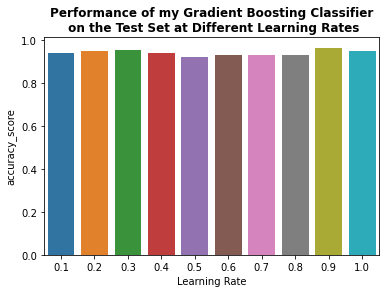

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the scores we obtain
sns.barplot(x = list(my_test_accuracy_scores.keys()), y = list(my_test_accuracy_scores.values()))
plt.xlabel("Learning Rate");
plt.ylabel("accuracy_score");
plt.title("Performance of my Gradient Boosting Classifier\n on the Test Set at Different Learning Rates", weight = "bold");

## Comparing my Model to sklearn's Implementation of Gradient Boosting Classifier

In [20]:
from sklearn.ensemble import GradientBoostingClassifier

# Now do the same thing for both the test and training data using the sklearn's Gradient Boosting Classifier

sklearn_test_accuracy_scores = dict()

for alpha in [x / 10 for x in range(1, 11)]:
    gb_clf = GradientBoostingClassifier(learning_rate = alpha, random_state = 1)
    gb_clf.fit(X_train, y_train)
    
    sklearn_test_predictions = gb_clf.predict(X_hat) 
    sklearn_test_accuracy_scores[alpha] = (y_test == sklearn_test_predictions).sum() / len(y_test)
    #sklearn_test_accuracy_scores[alpha] = accuracy_score(y_test, sklearn_test_predictions)

GradientBoostingClassifier(random_state=1)

GradientBoostingClassifier(learning_rate=0.2, random_state=1)

GradientBoostingClassifier(learning_rate=0.3, random_state=1)

GradientBoostingClassifier(learning_rate=0.4, random_state=1)

GradientBoostingClassifier(learning_rate=0.5, random_state=1)

GradientBoostingClassifier(learning_rate=0.6, random_state=1)

GradientBoostingClassifier(learning_rate=0.7, random_state=1)

GradientBoostingClassifier(learning_rate=0.8, random_state=1)

GradientBoostingClassifier(learning_rate=0.9, random_state=1)

GradientBoostingClassifier(learning_rate=1.0, random_state=1)

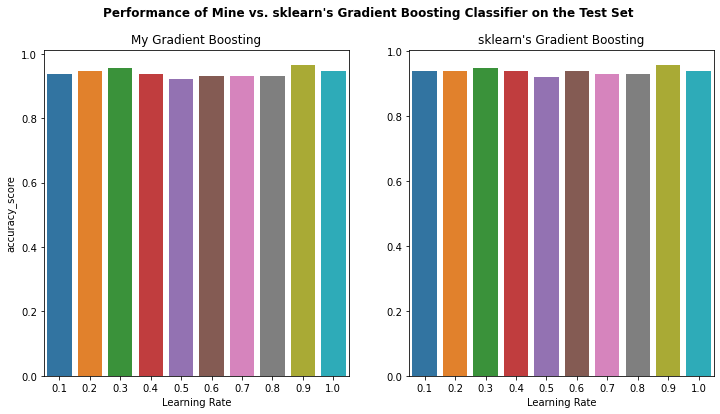

In [21]:
# Compare my Gradient Boosting Classifier with the one from sklearn by plotting side by side the scores each of them yields  
# on the test data

fig, axs = plt.subplots(1,2, figsize = (12, 6))

_ = sns.barplot(x = list(my_test_accuracy_scores.keys()), y = list(my_test_accuracy_scores.values()), ax = axs[0]);
_ = sns.barplot(x = list(sklearn_test_accuracy_scores.keys()), y = list(sklearn_test_accuracy_scores.values()), ax = axs[1]);

_ = axs[0].set_ylabel("accuracy_score")

for ax in axs:
    _ = ax.set_xlabel("Learning Rate")

_ = axs[0].set_title("My Gradient Boosting")    
_ = axs[1].set_title("sklearn's Gradient Boosting")    

_ = fig.suptitle("Performance of Mine vs. sklearn's Gradient Boosting Classifier on the Test Set", weight = "bold")